In [1]:
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion 
from scipy.ndimage.morphology import iterate_structure

# Finding Local Peaks in a 2D Array

## Toy Problem

We want to find the primary points of contact made by puppy-paws on a pressure-sensor. There are 4 images that are 11x14 pixels. 

The pressure-heatmap data is given below:

In [2]:
paws = np.loadtxt('paws.txt').reshape(4, 11, 14)
print(paws.shape)

(4, 11, 14)


<IPython.core.display.Javascript object>


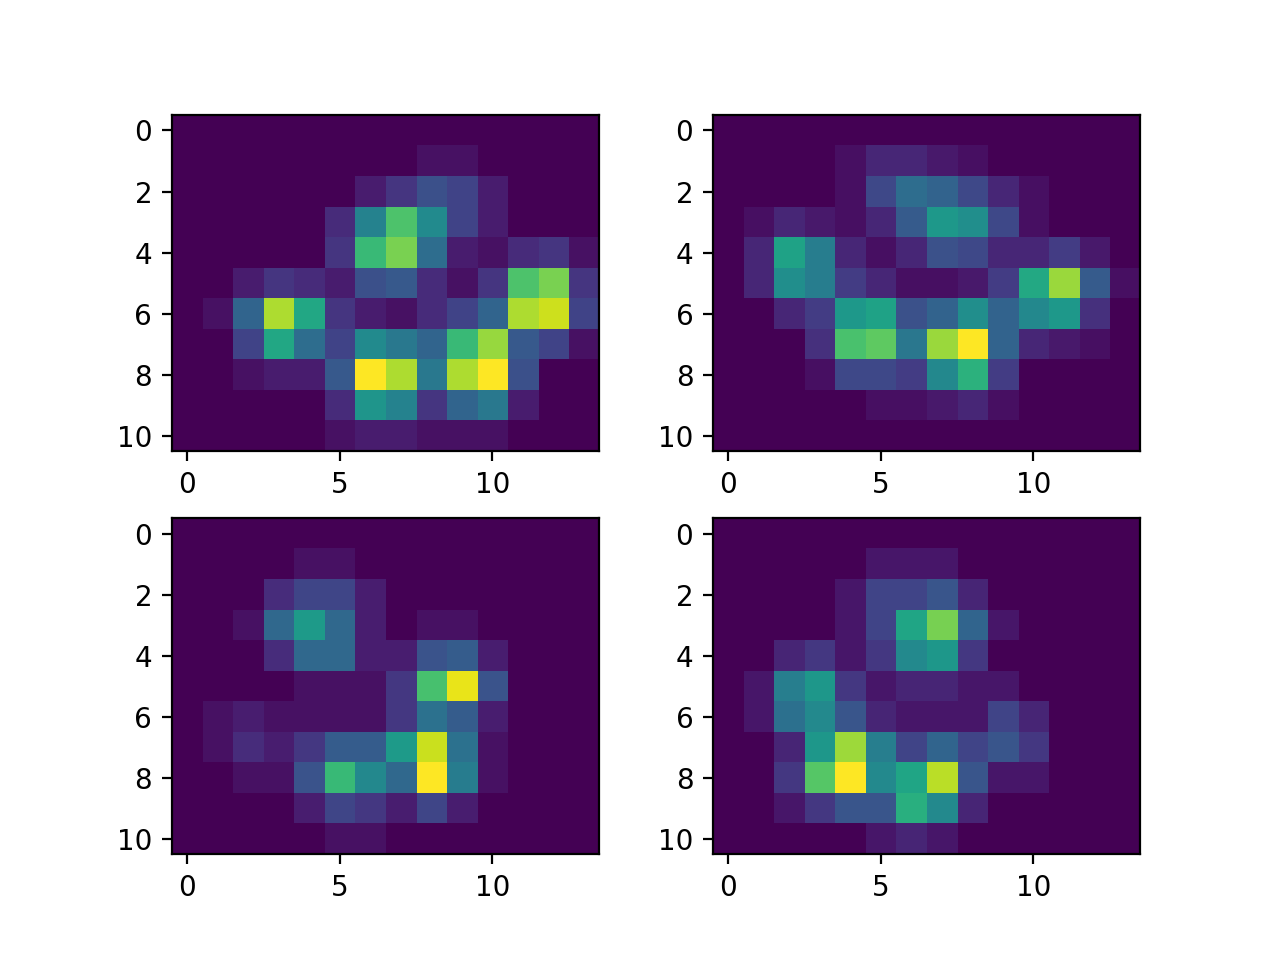

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for n, (i,j) in enumerate([(0,0), (0,1), (1,0), (1,1)]):
    ax[i, j].imshow(paws[n]);

For each "toe", we want to find the pixel with the maximum pressure. This corresponds to a finding the local peaks in a 2D image. This is much more nuanced than finding the global maximum. It is also not completely well defined - we need to specify what we mean by local.

### generate_binary_structure

We will use `scipy.ndimage.morphology.generate_binary_structure` to help us define the local neighborhood that we will consider, when looking for 2D peaks.

`generate_binary_structure` produces the footprint in which we look for neighbors. Using `generate_binary_structure(rank=2,connectivity=1)` means that, for a given pixel, we will check its two vertical and two horizontal neighbors when checking for the local maximum.


In [4]:
generate_binary_structure(rank=2,connectivity=1)

array([[False,  True, False],
       [ True,  True,  True],
       [False,  True, False]])

<IPython.core.display.Javascript object>


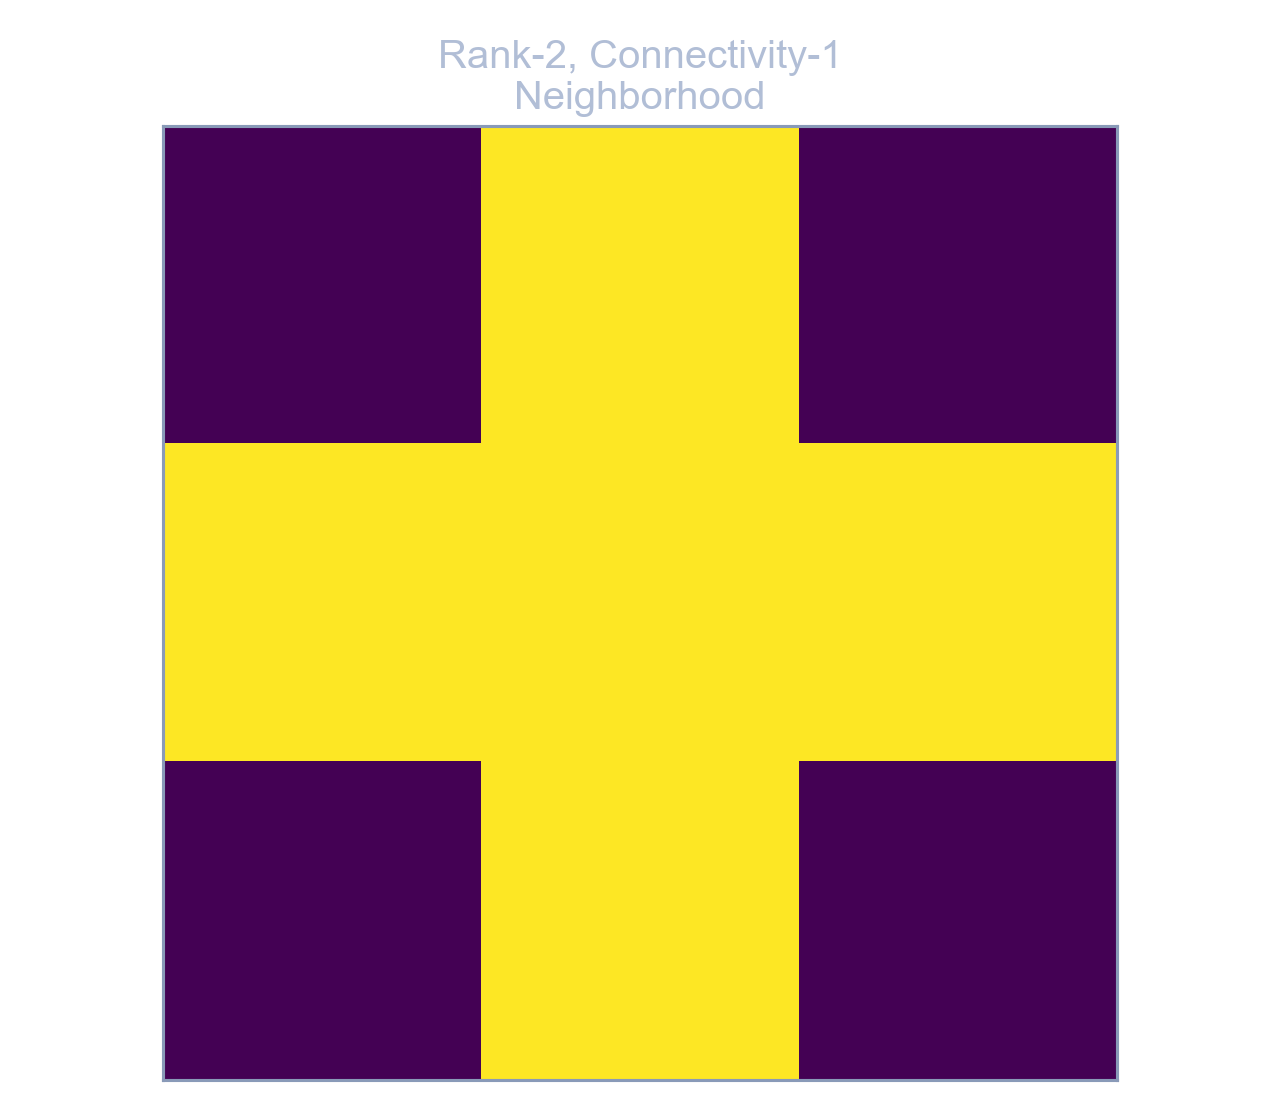

In [8]:
fig, ax = plt.subplots()
ax.imshow(generate_binary_structure(rank=2,connectivity=1))
ax.set_title("Rank-2, Connectivity-1\nNeighborhood")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

What is the "footprint" produced by `generate_binary_structure(rank=2,connectivity=2)`?

Boolean arrays behave like a binary mask when multiplied with a numerical array. Try multiplying the connectivity-1, rank-2 binary structure with a (3, 3)-shaped array of 2s. Try to predict what the result will be before running your code.

In [9]:
2*np.ones((3, 3)) * generate_binary_structure(2, 1)

array([[ 0.,  2.,  0.],
       [ 2.,  2.,  2.],
       [ 0.,  2.,  0.]])

### maximum_filter
`scipy.ndimage.filters.maximum_filter` is able to take a binary structure and use it to define a local "neighborhood", or "footprint" (wherever the footprint is `True`), within which it identifies the local maxima in an array. It rasters this footprint over our 2D array with the footprint centered at each element, and produces a 2D array of the same shape, but whose elements contain the local max values.

For example, consider the array of data:
```python
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
```

Given the binary foot print:
```python
fp = np.array([[False,  True, False],
               [ True,  True,  True],
               [False,  True, False]], dtype=bool)
```

Using this footprint, `maximum_filter` will look at the entry 4, above it, below it, to the left, and to the right, and will populate that position of the (3, 3) output array with the maximum in that footprint. Because there is no entry above 4, or to the left, `maximum_filter` will "mirror" the data across the boundary. This 'mode' of dealing with the boundary can be changed (see the docstring). The maximum value here is 4.

`maximum_filter` places the footprint centered at each element of the data array and populates the corresponding element of the output with the maximum value from the footprint. What will be the output of  `maximum_filter(data, footprint=fp)` be? Determine this by hand before running the code.

In [10]:
# SOLUTION
data = np.array([[ 4,  0,  5],
                 [ 2,  9,  1],
                 [10, -2,  1]])
fp = generate_binary_structure(2, 1)
maximum_filter(data, footprint=fp)

array([[ 4,  9,  5],
       [10,  9,  9],
       [10, 10,  1]])

Exercise: 

Given the data array
```python
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
```

Find `fp` such that

```python
>>> maximum_filter(data, footprint=fp)
array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])
```

Hint: Start with the four elements in the middle of the output. Keep in mind how border cases are handled by default


In [13]:
# SOLUTION
old_fp = np.array([[False,  True, False],
                   [ True,  True,  True],
                   [False,  True, False]], dtype=bool)

# The symbol ~ is "not" in boolean logic: 
# ~True -> False,  ~False -> True
fp = ~old_fp
print(fp)

[[ True False  True]
 [False False False]
 [ True False  True]]


In [15]:
data = np.array([[ 2,   14,  10,  5],
                 [ -1,  19,   1,  4],
                 [ 10,  -2,   7,  2],
                 [  9,   8,   4,  6]])
maximum_filter(data, footprint=fp)

array([[19, 10, 19, 10],
       [14, 10, 14, 10],
       [19,  9, 19,  6],
       [10, 10,  8,  7]])

What if we want to use a larger footprint? We can make use of `scipy.ndimage.morphology.iterate_structure`. This allows us to set roughly the number of nearest neighbors (along a given direction) that that we want to included in the footprint.

For instance:
```python
>>> fp = generate_binary_structure(2,1)
>>> iterate_structure(fp, 2)
array([[False, False,  True, False, False],
       [False,  True,  True,  True, False],
       [ True,  True,  True,  True,  True],
       [False,  True,  True,  True, False],
       [False, False,  True, False, False]], dtype=bool)
```

<IPython.core.display.Javascript object>


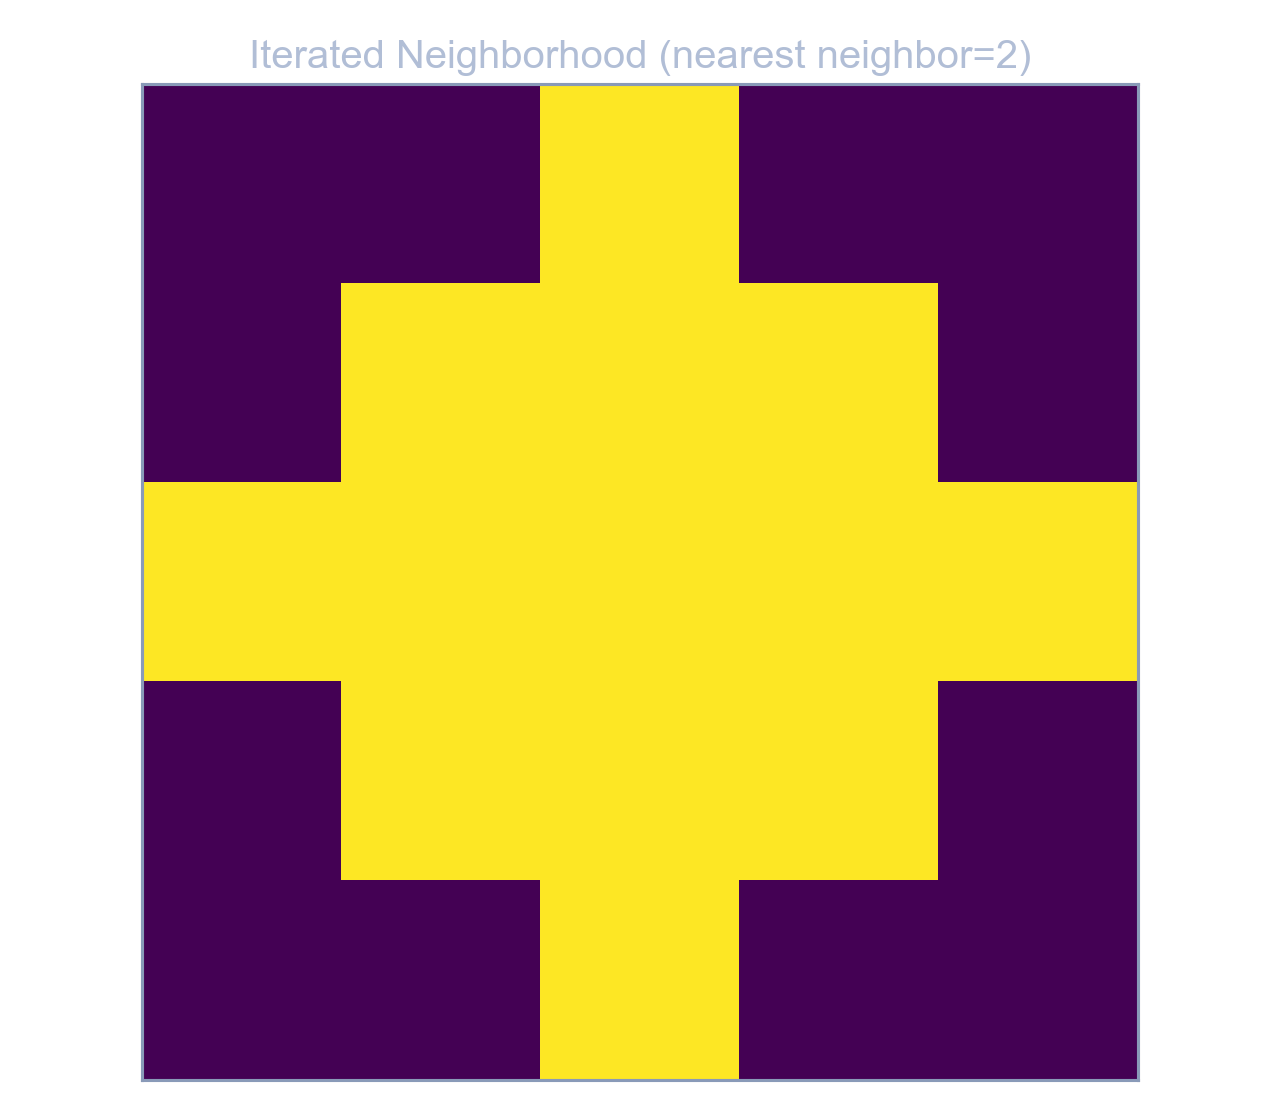

In [16]:
fig, ax = plt.subplots()
fp = generate_binary_structure(2,1)
ax.imshow(iterate_structure(fp, 2))
ax.set_title("Iterated Neighborhood (nearest neighbor=2)")
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([]);

### Finding the Actual Peaks
What we are after are the local peaks in our data. `maximum_filter` essentially smears the local maxima over our data. We can simply see where our data matches with the max-filtered data - these points of agreement should be our local peaks!

That is
```python
peaks = (data == maximum_filter(data, footprint=fp))
```

`peaks` is thus an array of 1s wherever there is a local peak, and 0s elsewhere. Let's write a function that takes in a 2D array of data, and returns this binary indicator of the local peaks in the data. Let's use the rank-2, connectivity-2 footprint. Call the function `local_peaks_v1`. Thus "local" here means a 3x3 neighborhood.

In [17]:
# SOLUTION
def local_peaks_v1(data):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        1 indicates a local peak. """
    fp = generate_binary_structure(2, 2)
    return data == maximum_filter(data, footprint=fp)

Here is a function that will plot the paw prints next to the binary indicator of the local peaks.

In [18]:
def plot_compare(data, peak_finding_function):
    """ Plot the original data side-by-side with the binary indicator
        for the local peaks.
        
        Parameters
        ----------
        data : numpy.ndarray, shape=(N, H, W)
            N 2D arrays of shape (H, W)
            
        peak_finding_function : Callable[ndarray, ndarray]
            Returns local peak indicator for 2D array"""
    fig, ax = plt.subplots(nrows=len(data), ncols=2)
    for i, dat in enumerate(data):
        ax[i, 0].imshow(dat)
        ax[i, 1].imshow(peak_finding_function(dat))
    return fig, ax

Now plot a comparison to assess how well our peak-finding function works.

<IPython.core.display.Javascript object>


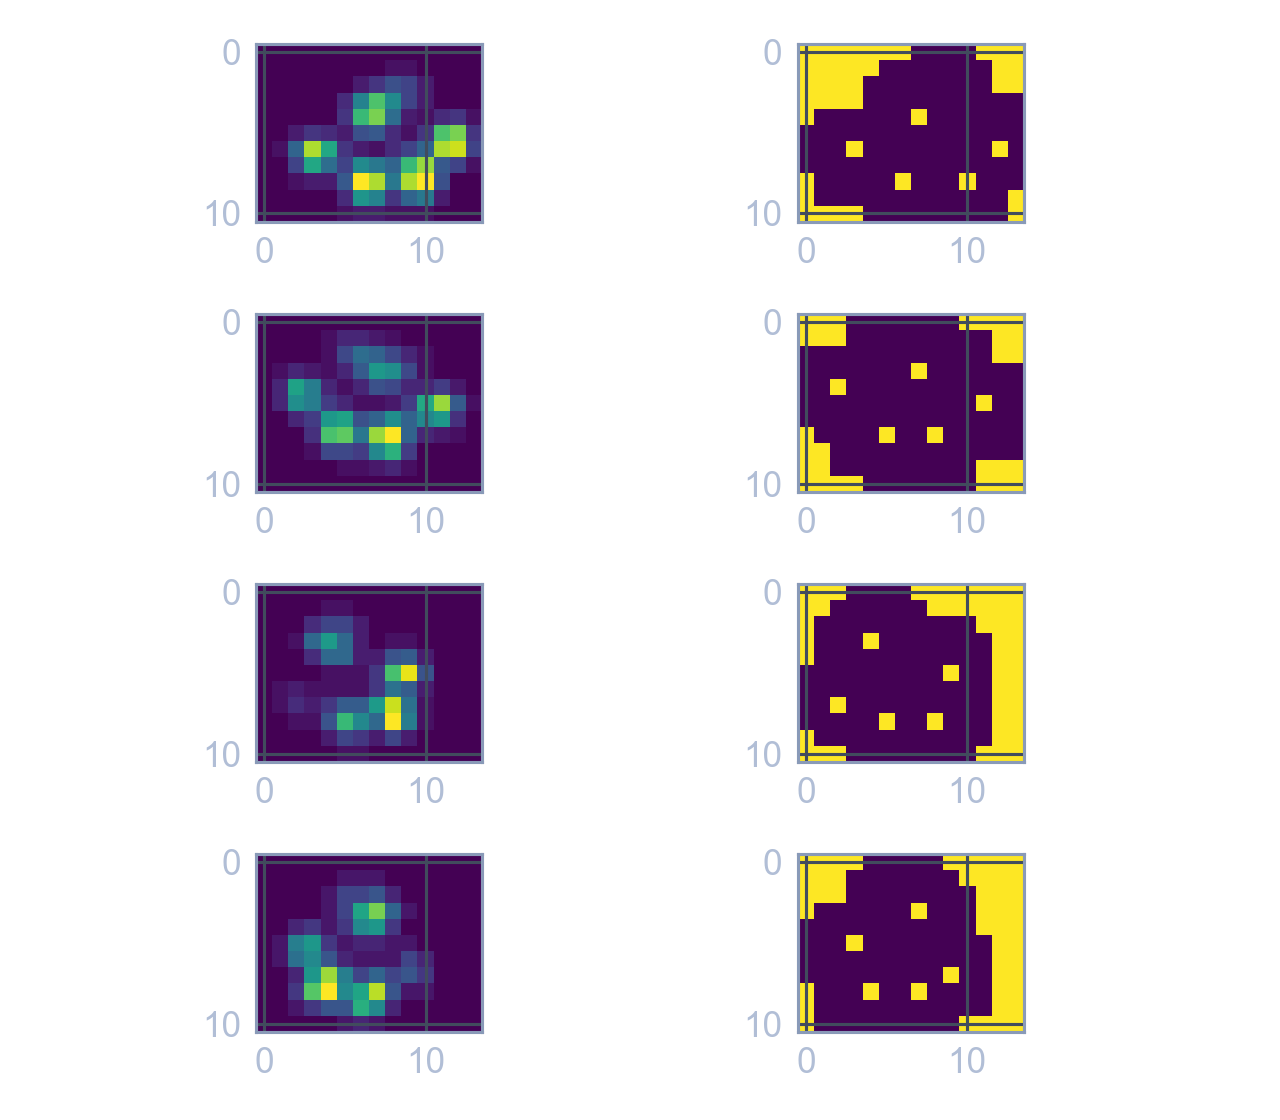

In [19]:
# SOLUTION
plot_compare(paws, local_peaks_v1);

What do you see in these right-column images? Are these precisely the results we are looking for? What do we need to add to our algorithm, if anything?
> SOLUTION: No, the regions of the image that are blanketed in background (== 0) are also considered to be local peaks, since there are no smaller or larger points in their vicinity. We need to subtract out the background from the image. We can do this by finding `foreground = (data > 0)`, and requiring that the returned values are local peaks *and* are located in the foreground.

In [21]:
# SOLUTION
def local_peaks_v2(data):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        1 indicates a local peak. """
    fp = generate_binary_structure(2, 2)
    local = data == maximum_filter(data, footprint=fp)
    foreground = data > 0
    
    # (x & y) is equivalent to np.logical_and(x, y)
    return local & foreground

<IPython.core.display.Javascript object>


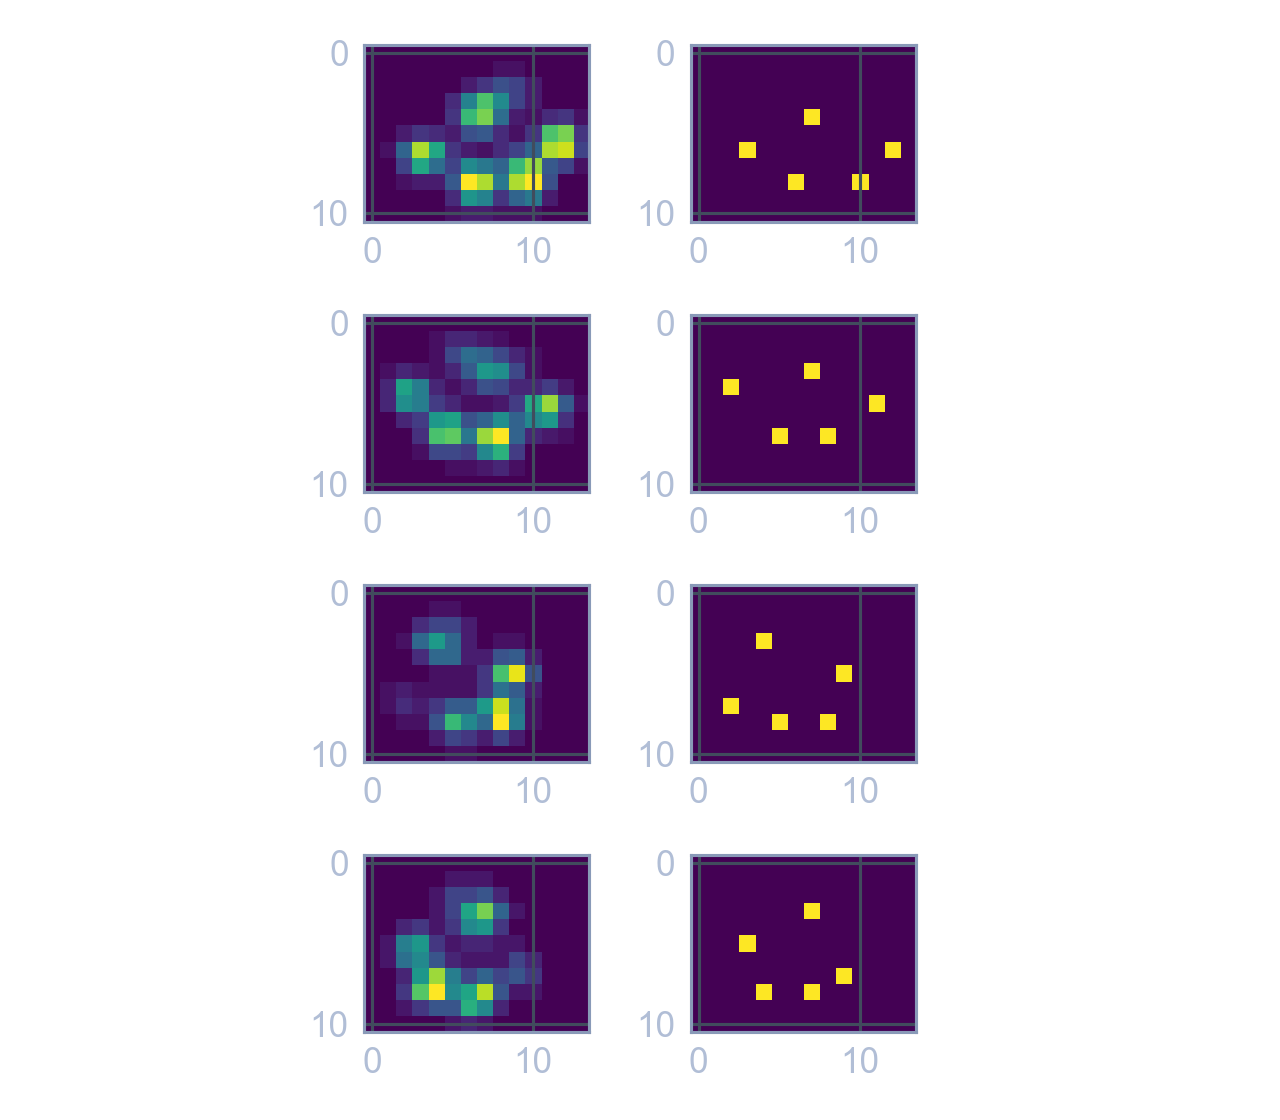

In [22]:
# SOLUTION
plot_compare(paws, local_peaks_v2);

Success! We are now finding local peaks in 2D data!

To summarize this process, we:
 - Determined a neighborhood that was appropriate for measuring local peaks.
 - Created a max-filtered version of our data.
 - Found the local peaks by finding where the data and the max-filtered data agree.
 - Demanded that our local peaks be in the "foreground" of our data.
 
This will be very useful to help us find the "fingerprint features" of a song, given its spectrogram (frequency vs time) data.

## Identifying "Foreground" vs "Background" in Real Data

Although this puppy paw print data set is pretty adorable, the fact that the paw print features are neatly embedded in a background of 0s is too convenient. In reality, you will likely face data where distinguishing background from a salient foreground is subtle (or perhaps entirely ill-posed).

Let's consider, for instance,  the spectrogram data for the trumpet waveform.

In [2]:
# running this cell loads the PCM-encoded data for the trumpet clip
with open("../fourier_materials/data/trumpet.txt", 'r') as R:
    trumpet_audio = np.asarray([int(i) for i in R])
    
sampling_rate = 44100 # sampling rate in Hz

<IPython.core.display.Javascript object>


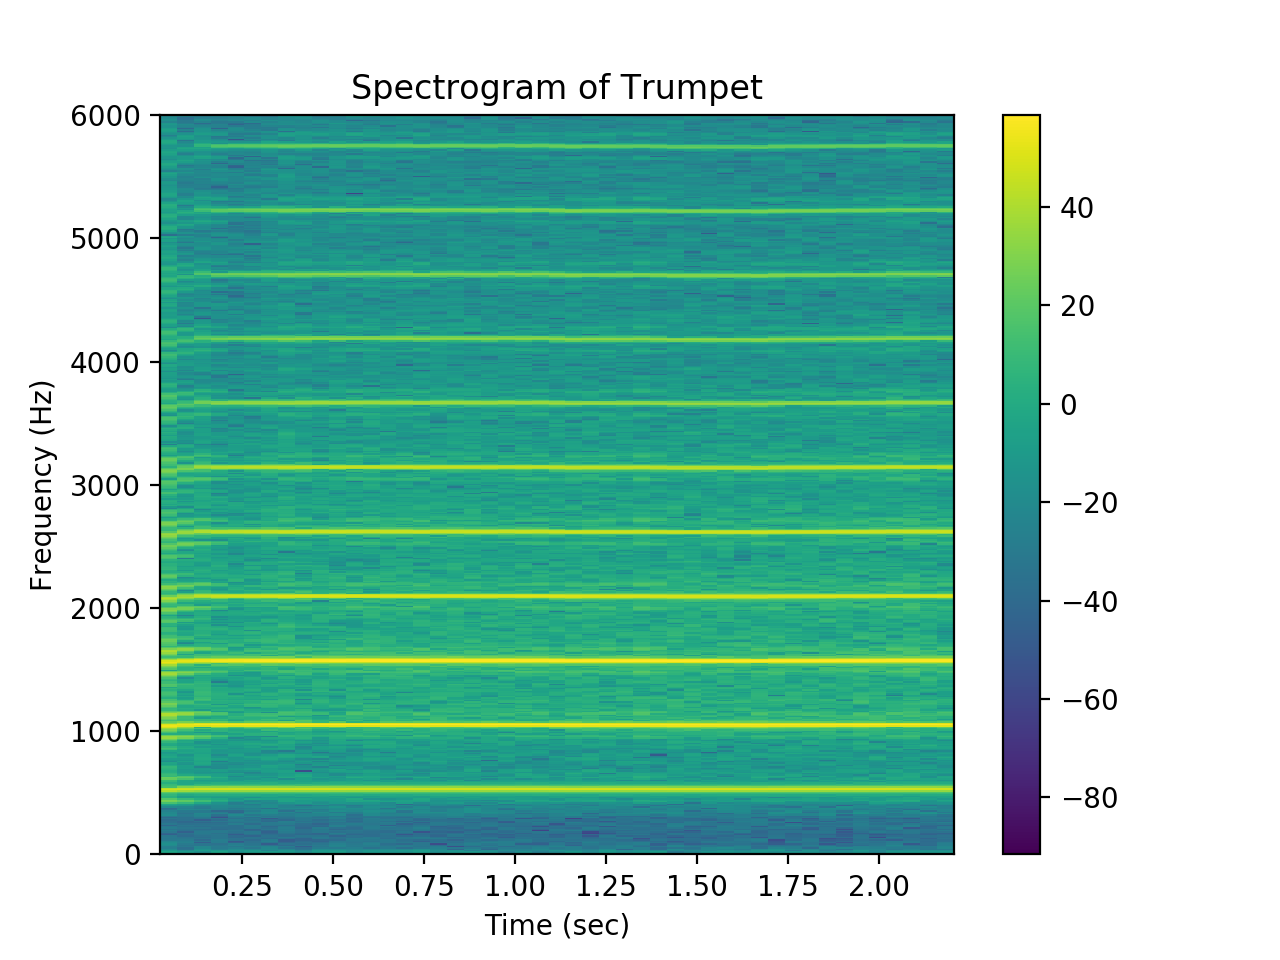

In [3]:
# using matplotlib's built-in spectrogram function
fig, ax = plt.subplots()

S, freqs, times, im = ax.specgram(trumpet_audio, NFFT=4096, Fs=sampling_rate,
                                  window=mlab.window_hanning,
                                  noverlap=4096 // 2)
fig.colorbar(im)

ax.set_xlabel("Time (sec)")
ax.set_ylabel("Frequency (Hz)")
ax.set_title("Spectrogram of Trumpet")
ax.set_ylim(0, 6000);

To help us identify a "foreground" in the log-amplitudes of the spectrogram, we will plot the *cumulative distribution* of the log-amplitudes. This will allow us the threshold that delimits a given percentile of the amplitudes.

We will form a histogram of our Fourier coefficient log-amplitudes, $\log(|c_{k}|)$, using some bin size $\Delta c$ to bin those log-amplitudes. We will normalize the bin counts such that:

\begin{equation}
\sum_{i=0}^{N_{bin}}cnt_{i} \Delta c = 1
\end{equation}

That is, if you multiply the normalized histogram bin-count with the bin size and sum all of these terms, you get 1. This means that bin counts have been normalized such that the "area" of our histogram is 1.

Flatten your spectrogram data and pass it to the function `numpy.histogram`. If $N$ is the number of Fourier log-amplitudes, $\log(|c_{k}|)$, in your flattened spectrogram, then instruct the histogram to use $N/2$ bins. Also, be sure to specify `density=True` so that the bin counts are normalized to satisfy the above relationship. Be sure to read the "Returns" section of the doc-string for `numpy.histogram` to understand what the function returns. 

In [6]:
# SOLUTION
# binning our amplitudes an normalize the "density" of the counts.
bin_counts, bin_edges = np.histogram(np.log(S.flatten()), bins=S.size//2, density=True)

If you create a matplotlib figure via 

```python
fig, ax = plt.subplots()
``` 

You can use `ax.hist` in the exact same way as `numpy.histogram` but to plot this normalized histogram. Pass `ax.hist` the same arguments as `numpy.histogram` with one exception: **instruct the histogram to use $N/200$ bins instead of $N/2$**. Be  sure to label your axes.

<IPython.core.display.Javascript object>


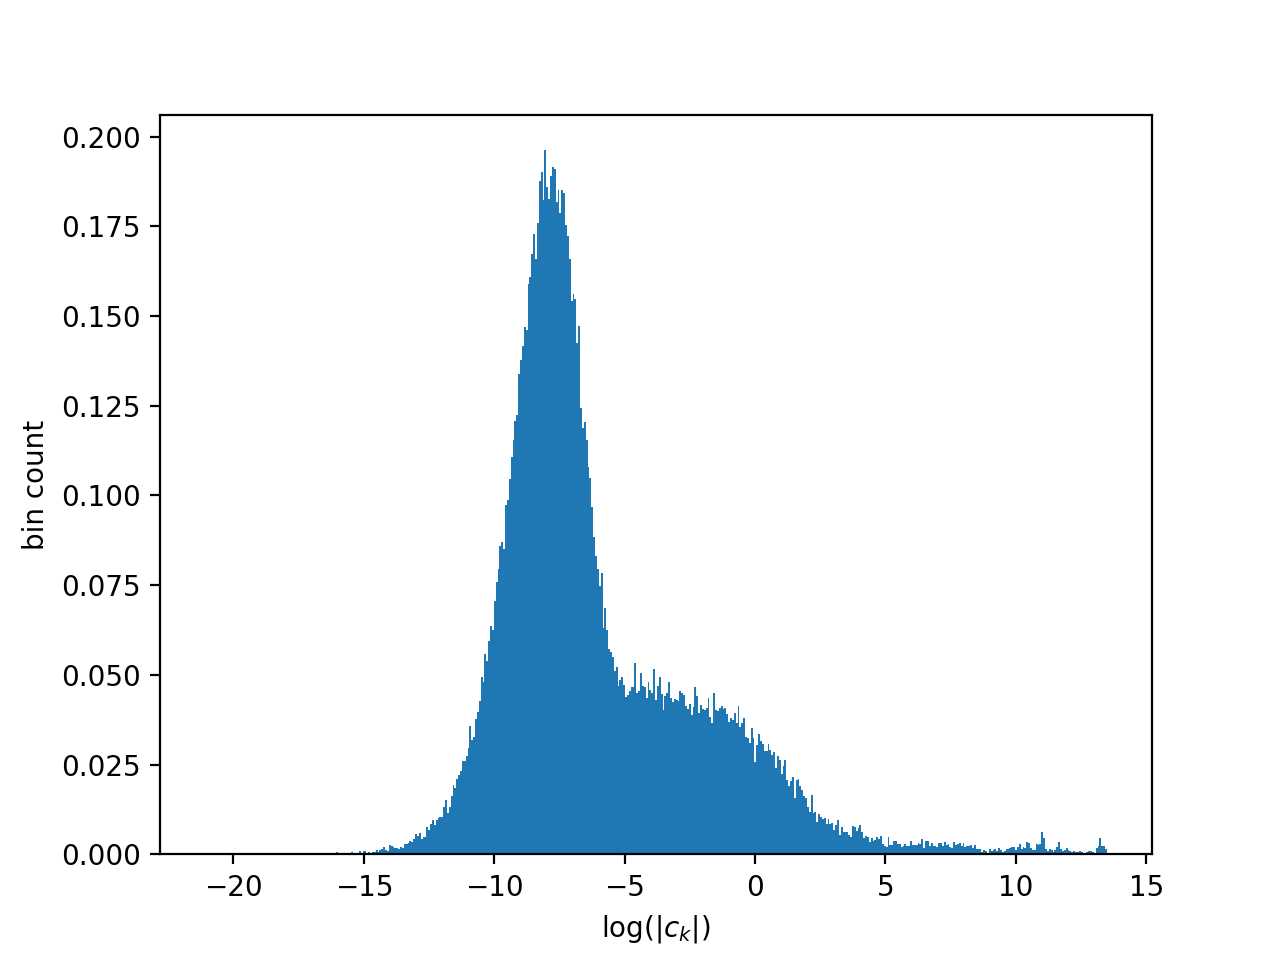

In [5]:
# SOLUTION

fig, ax = plt.subplots()
ax.hist(np.log(S.flatten()), bins=S.size//200, density=True)
ax.set_xlabel(r"$\log(|c_{k}|)$")
ax.set_ylabel("bin count");

Using the output of `numpy.histogram`, check that the summation relation holds true; i.e. that the area of this histogram is 1.

In [7]:
# SOLUTION
np.sum(bin_counts * np.diff(bin_edges))

0.9999999999999999

Now that we have our normalized binned-counts of our amplitudes, we can form our cumulative distribution as follows:

\begin{equation}
F_{j} = \sum_{i=0}^{j}cnt_{i} \Delta c
\end{equation}

Where $F_{j}$ is the $j$th element in our cumulative distribution, for $j=0, 1, \cdots, (N_{bin}-1)$. Thus $F_{j}$ represents the total area of the histogram up to bin-$j$.

Compute the cumulative distribution $F$. Assign the variable `cumulative_distr` to the resulting array.

In [8]:
# SOLUTION

# cumsum([x0, x1, x2, x3, ...]) -> [x0, x0+x1, x0+x1+x2, x0+x1+x2+x3, ...]
cumulative_distr = np.cumsum(bin_counts * np.diff(bin_edges))

Now plot $F_{j}$ vs $c_{j}$ where $c_{j} = \sum_{i=0}^{j}\Delta c$. Thus $c_{j}$ is the log-amplitude value associated with bin-$j$.

<IPython.core.display.Javascript object>


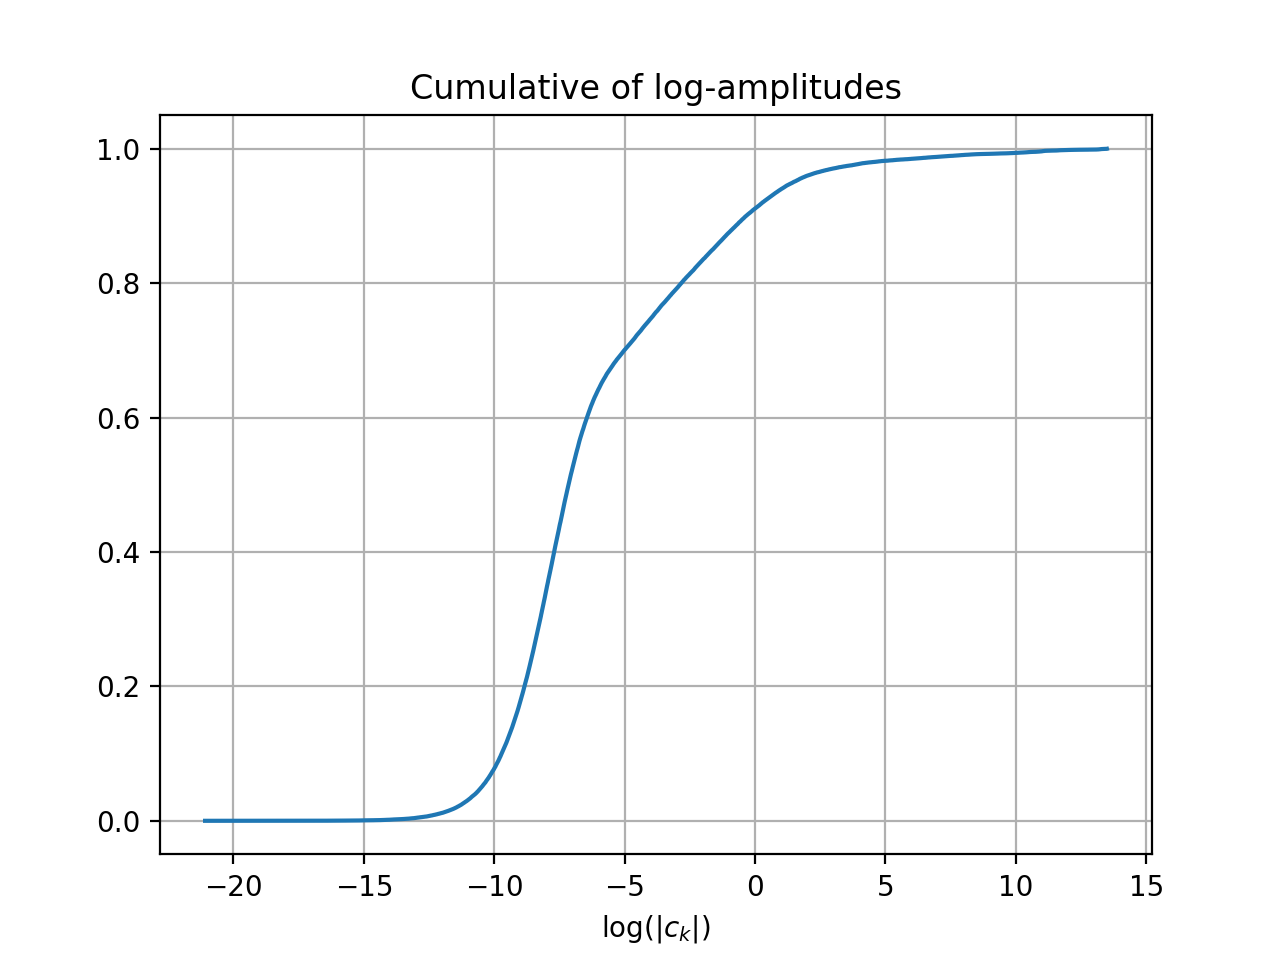

In [9]:
fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], cumulative_distr)
ax.set_xlabel(r"$\log(|c_{k}|)$")
ax.set_title("Cumulative of log-amplitudes")
ax.grid(True)

This distribution permits us to look up the percentiles of the log-amplitudes. For example, we can find the log-amplitude below which 80% of all the other present log-amplitudes fall. According to the plot above, we see that roughly 90% of all the log-amplitudes in our spectrogram fall beneath the value 0.

We can now consult this distribution when deciding how to distinguish between background and foregrounds. Suppose that we only want to detect peaks among the highest 10% of amplitudes present in the spectrogram. We want to lookup the log-amplitude in our cumulative distribution that maps to 0.9. 

`numpy.searchsorted` can be used to retrieve the index of `cumulative_distr` that is closest to 0.9, we can then use this index to determine which amplitude bin this corresponds to.

In [10]:
frac_cut = 0.9
bin_index_of_cutoff = np.searchsorted(cumulative_distr, frac_cut)

# given the bin-index, we want the associated log-amplitude value for that bin
cutoff_log_amplitude = bin_edges[bin_index_of_cutoff]
print(cutoff_log_amplitude)

-0.3460759730788432


Thus 90% of all the log-amplitudes in the spectrogram fall below $-0.346$. Thus 90% of all of the Fourier coefficient amplitudes in this audio clip, $|c_{k}|$, fall beneath $e^{-0.346} \approx 0.71$. 

We could use this as a cutoff value of $-0.346$ for distinguishing foreground from background when finding peaks in the spectrogram for our trumpet audio clip!

Rewrite your local peaks function so that you can pass a cutoff value, where elements in your data that are less than or equal to that cutoff are considered "background".

In [25]:
# SOLUTION
def local_peaks_final(data, cutoff):
    """ Find local peaks in a 2D array of data.
    
        Parameters
        ----------
        data : numpy.ndarray
        
        cutoff : float
             A threshold value that distinguishes background from foreground
             
        Returns
        -------
        Binary indicator, of the same shape as `data`. The value of
        1 indicates a local peak. """
    fp = generate_binary_structure(2, 2)
    local = data == maximum_filter(data, footprint=fp)
    foreground = data > cutoff
    
    # (x & y) is equivalent to np.logical_and(x, y)
    return local & foreground